## 1) Implementation of easy21

First we need to develope an enviroment that implements the game "easy21". For this purpose we only need to define a step function, which performes a move in the game or a step in the MDP.

Fistly we create a class to hold the state, for our conviniece. It should be noted that for the algorithms to be followed, it's convinient to use a single number to represent each state. What is more, it's helpful to include an virtual 'terminal' state. So our step function takes numbers as states and actions, internally converts them to *State* instances and *Strings*, and then back to numbers.

In [1]:
import numpy as np

In [2]:
class State:
    def __init__(self, dealer, player):
        self.dealer = dealer
        self.player = player


In [3]:
def step(s, a):
    """
    Takes as input a state and an action and 
    returns a new state and a reward.
    """
    
    # Just make sure our input have an actual meaning in the game setting
    assert(s >= 0 and s <= 209)
    assert(a >= 0 and a <= 1)
    
    # Convert numbers to State and String instances
    state = State(s//21 + 1, s%21 + 1)
    action = ['hit', 'stick'][a]
    
    if action == 'hit':
        # Draw another card (e.g. [5, black])
        new_card = [np.random.choice(np.arange(1, 11)),
                    np.random.choice(['red', 'black'], p=[1/3, 2/3])]
        
        # Compute new state
        new_state = State(state.dealer, state.player)
        if new_card[1] == 'black':
            new_state.player += new_card[0]
        else:
            new_state.player -= new_card[0]
            
        # Compute reward
        if new_state.player > 21 or new_state.player < 1:
            new_state = 'terminal'
            reward = -1
        else:
            reward = 0
    else:       
        # Dealer starts taking turns
        while (state.dealer < 17):
            # Draw another card (e.g. [5, black])
            new_card = [np.random.choice(np.arange(1, 11)),
                        np.random.choice(['red', 'black'], p=[1/3, 2/3])]

            # Compute new state
            if new_card[1] == 'black':
                state.dealer += new_card[0]
            else:
                state.dealer -= new_card[0]
                
        # Game has terminated
        new_state = 'terminal'
        
        # Compute reward
        if state.dealer > 21 or state.dealer < 1:
            reward = 1
        elif state.dealer > state.player:
            reward = -1
        elif state.dealer == state.player:
            reward = 0
        else:
            reward = 1
    
    # Convert state back to number
    if new_state == 'terminal':
        new_state = 210
    else:
        new_state = (new_state.dealer-1) * 21 + (new_state.player-1)
    
    return new_state, reward

## 2)Monte-Carlo Control in easy21

We develope the Monte-Carlo algorithm below. The algorithm simulates playing the game a random initial position. Alternatively we could go for each initial position possible (e.g. all possible combinations of the first hands). It returns the policy learned plus its optimal values:

In [4]:
def MonteCarlo(states, actions, startingStates, episodes):
    '''
    Uses q-Learning to computer the optimal policy for 
    the Easy-21 game
    '''
    N0 = 100
    N = np.zeros(states.shape + actions.shape)
    Q = np.zeros(states.shape + actions.shape)
    Q_obs = np.zeros(states.shape + actions.shape)
    
    # Run the same simulations many times
    for episode in range(episodes):
        # Episode starts with player and dealer drawing a black card
        s = np.random.choice(startingStates)
        
        while(True):
            # Choose next move
            epsilon = N0 / (N0 + np.sum(N[s, :]))
            if np.random.rand() < epsilon:
                a = np.random.choice(actions) # random action
            else:
                a = np.argmax(Q[s, :])        # optimal action

            # Get next state
            next_s, r = step(s, a)
            N[s, a] += 1

            # Exit upon arrival on the end state
            Q_obs[s, a] = r + max(Q[next_s, :])

            # Update
            alpha = 1 / N[s, a]
            Q[s, a] = (1 - alpha) * Q[s, a] + alpha * Q_obs[s, a]

            if next_s == 210:
                break
            else:
                s = next_s
                
    states = states[:-1] # exclude terminal state
                  
    # Optimal policy
    V = np.zeros(states.shape)
    policy = -np.ones(states.shape)
    for s in states:
        V[s] = np.max(Q[s, :])
        policy[s] = np.argmax(Q[s, :])
    
    # Convert policies into tables with more natural meaning
    return policy.reshape(10, 21), V.reshape(10, 21)


It would be cool to have a visualization function for our results:

In [5]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

def plot(V):
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    X, Y = np.meshgrid(np.arange(1, 11), np.arange(1, 22))
    surf = ax.plot_surface(X, Y, V.transpose(),
                           cmap=cm.coolwarm,
                           linewidth=0,
                           antialiased=False)

We run the Monte-Carlo simulation 200 times (episodes) for each starting state.

In [6]:
states = np.arange(211)
actions = np.arange(2)
startingStates = []
for i in np.arange(10):
    for j in np.arange(10):
        startingStates.append(i*21 + j)

policy, V = MonteCarlo(states, actions, startingStates, 10000)

Now lets see what our model learned. As we can see bellow the model assigns higher rewards to player states close to 21. What is more there is a bump in the middle signifying that the player has room to draw another card and obtain a score closer to 21. As we see the initial hand of the dealer doesn't provide any useful information, which makes sence.

Finally about the policy we see that our model learns to 'hit' when the hand score is up to 17, but 'stick' when it's over that number.

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]]


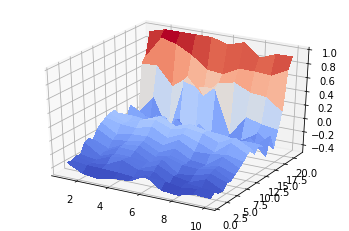

In [7]:
print(policy)
plot(V)